In [2]:
"""
Santiment API Client
Retrieve social volume, weighted sentiment, exchange flows, addresses, MVRV, and NPL data
"""

import requests
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Union
import logging
import pytz
from pydantic import BaseModel

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SantimentData(BaseModel):
    """Data model for Santiment metrics"""
    slug: str
    metric: str
    datetime: datetime
    value: Union[float, int, None]
    metadata: Optional[Dict] = {}

class SantimentClient:
    """Client for Santiment API"""

    def __init__(self, api_key: str):
        """
        Initialize Santiment client

        Args:
            api_key: Santiment API key
        """
        self.api_key = api_key
        self.base_url = "https://api.santiment.net/graphql"
        self.session = requests.Session()
        self.session.headers.update({
            'Authorization': f'Apikey {api_key}',
            'Content-Type': 'application/json'
        })

        # Available metrics - ONLY the ones you specified (corrected based on API errors)
        self.metrics = {
            'daily_active_addresses': 'daily_active_addresses',
            'circulation': 'circulation',
            'mvrv_usd': 'mvrv_usd_30d',
            'whale_transaction_count': 'whale_transaction_count_1m_usd_to_inf',
            'transaction_volume_in_profit_or_loss': 'transaction_volume_in_profit',
            'mean_dollar_invested_age': 'mean_dollar_invested_age',
            'npl': 'network_profit_loss',
            'supply_on_exchanges': 'supply_on_exchanges',
            'exchange_flow_balance': 'exchange_balance',
            'social_volume': 'social_volume_total',
            'social_dominance': 'social_dominance_total',
            'weighted_sentiment': 'sentiment_balance_total',
            'market_cap_usd': 'marketcap_usd'
        }

    def query_graphql(self, query: str) -> Dict:
        """Execute GraphQL query"""
        try:
            response = self.session.post(
                self.base_url,
                json={'query': query},
                timeout=30
            )
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            logger.error(f"GraphQL query failed: {e}")
            raise

    def get_metric_data(
        self,
        slug: str,
        metric: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """
        Get metric data for a specific asset

        Args:
            slug: Asset slug (e.g., 'bitcoin', 'ethereum')
            metric: Metric name from self.metrics
            from_date: Start date
            to_date: End date
            interval: Time interval ('1h', '1d', '7d')
        """

        # Convert metric name to Santiment metric
        santiment_metric = self.metrics.get(metric, metric)

        # Format dates
        from_str = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
        to_str = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')

        query = f"""
        {{
            getMetric(metric: "{santiment_metric}") {{
                timeseriesData(
                    slug: "{slug}"
                    from: "{from_str}"
                    to: "{to_str}"
                    interval: "{interval}"
                ) {{
                    datetime
                    value
                }}
            }}
        }}
        """

        try:
            result = self.query_graphql(query)

            if 'errors' in result:
                logger.error(f"GraphQL errors: {result['errors']}")
                return []

            data_points = result.get('data', {}).get('getMetric', {}).get('timeseriesData', [])

            santiment_data = []
            for point in data_points:
                if point['value'] is not None:
                    santiment_data.append(SantimentData(
                        slug=slug,
                        metric=metric,
                        datetime=datetime.fromisoformat(point['datetime'].replace('Z', '+00:00')),
                        value=point['value'],
                        metadata={'santiment_metric': santiment_metric, 'interval': interval}
                    ))

            logger.info(f"Retrieved {len(santiment_data)} data points for {slug} {metric}")
            return santiment_data

        except Exception as e:
            logger.error(f"Error retrieving {metric} for {slug}: {e}")
            return []

    def get_social_volume(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get social volume data"""
        return self.get_metric_data(slug, 'social_volume', from_date, to_date, interval)

    def get_weighted_sentiment(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get weighted sentiment data"""
        return self.get_metric_data(slug, 'weighted_sentiment', from_date, to_date, interval)

    def get_exchange_flows(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> Dict[str, List[SantimentData]]:
        """Get exchange inflow and outflow data"""
        inflow = self.get_metric_data(slug, 'exchange_inflow', from_date, to_date, interval)
        outflow = self.get_metric_data(slug, 'exchange_outflow', from_date, to_date, interval)

        return {
            'inflow': inflow,
            'outflow': outflow
        }

    def get_address_metrics(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> Dict[str, List[SantimentData]]:
        """Get address creation and usage metrics"""
        active = self.get_metric_data(slug, 'active_addresses', from_date, to_date, interval)
        new = self.get_metric_data(slug, 'new_addresses', from_date, to_date, interval)

        return {
            'active_addresses': active,
            'new_addresses': new
        }

    def get_mvrv(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get MVRV (Market Value to Realized Value) data"""
        return self.get_metric_data(slug, 'mvrv_usd', from_date, to_date, interval)

    def get_npl(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Network Profit/Loss data"""
        return self.get_metric_data(slug, 'npl', from_date, to_date, interval)

    def get_daily_active_addresses(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Daily Active Addresses data"""
        return self.get_metric_data(slug, 'daily_active_addresses', from_date, to_date, interval)

    def get_circulation(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Circulation data"""
        return self.get_metric_data(slug, 'circulation', from_date, to_date, interval)

    def get_funding_rate(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Funding Rate data"""
        return self.get_metric_data(slug, 'funding_rate', from_date, to_date, interval)

    def get_whale_transaction_count(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Whale Transaction Count data"""
        return self.get_metric_data(slug, 'whale_transaction_count', from_date, to_date, interval)

    def get_supply_distribution(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Supply Distribution data"""
        return self.get_metric_data(slug, 'supply_distribution', from_date, to_date, interval)

    def get_transaction_volume_in_profit_or_loss(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Transaction Volume in Profit or Loss data"""
        return self.get_metric_data(slug, 'transaction_volume_in_profit_or_loss', from_date, to_date, interval)

    def get_mean_dollar_invested_age(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Mean Dollar Invested Age data"""
        return self.get_metric_data(slug, 'mean_dollar_invested_age', from_date, to_date, interval)

    def get_supply_on_exchanges(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Supply on Exchanges data"""
        return self.get_metric_data(slug, 'supply_on_exchanges', from_date, to_date, interval)

    def get_exchange_flow_balance(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Exchange Flow Balance data"""
        return self.get_metric_data(slug, 'exchange_flow_balance', from_date, to_date, interval)

    def get_social_dominance(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Social Dominance data"""
        return self.get_metric_data(slug, 'social_dominance', from_date, to_date, interval)

    def get_market_cap_usd(
        self,
        slug: str,
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> List[SantimentData]:
        """Get Market Cap USD data"""
        return self.get_metric_data(slug, 'market_cap_usd', from_date, to_date, interval)

    def get_all_metrics(
        self,
        slugs: List[str],
        from_date: datetime,
        to_date: datetime,
        interval: str = '1d'
    ) -> Dict[str, Dict[str, List[SantimentData]]]:
        """
        Get all available metrics for multiple assets using a single GraphQL query

        Args:
            slugs: List of asset slugs (e.g., ['bitcoin', 'ethereum'])
            from_date: Start date
            to_date: End date
            interval: Time interval ('1h', '1d', '7d')

        Returns:
            Dictionary with structure: {slug: {metric: [SantimentData]}}
        """
        logger.info(f"Fetching all metrics for {len(slugs)} assets from {from_date} to {to_date}")

        # Format dates
        from_str = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
        to_str = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')

        # Build single GraphQL query for all slugs and all metrics
        query_parts = []

        for slug in slugs:
            for metric_key, santiment_metric in self.metrics.items():
                query_parts.append(f"""
                {slug}_{metric_key}: getMetric(metric: "{santiment_metric}") {{
                    timeseriesData(
                        slug: "{slug}"
                        from: "{from_str}"
                        to: "{to_str}"
                        interval: "{interval}"
                    ) {{
                        datetime
                        value
                    }}
                }}""")

        query = f"{{{''.join(query_parts)}}}"

        try:
            result = self.query_graphql(query)

            if 'errors' in result:
                logger.error(f"GraphQL errors: {result['errors']}")
                return {}

            # Parse results into structured format
            all_data = {}

            for slug in slugs:
                all_data[slug] = {}

                for metric_key in self.metrics.keys():
                    query_key = f"{slug}_{metric_key}"
                    data_points = result.get('data', {}).get(query_key, {}).get('timeseriesData', [])

                    santiment_data = []
                    for point in data_points:
                        if point['value'] is not None:
                            santiment_data.append(SantimentData(
                                slug=slug,
                                metric=metric_key,
                                datetime=datetime.fromisoformat(point['datetime'].replace('Z', '+00:00')),
                                value=point['value'],
                                metadata={'santiment_metric': self.metrics[metric_key], 'interval': interval}
                            ))

                    all_data[slug][metric_key] = santiment_data

            # Summary
            total_points = sum(
                len(data)
                for slug_data in all_data.values()
                for data in slug_data.values()
            )
            logger.info(f"Retrieved {total_points} total data points across {len(slugs)} assets and {len(self.metrics)} metrics")

            return all_data

        except Exception as e:
            logger.error(f"Error retrieving all metrics: {e}")
            return {}

    def to_dataframe(self, data: List[SantimentData]) -> pd.DataFrame:
        """Convert SantimentData list to pandas DataFrame"""
        if not data:
            return pd.DataFrame()

        df_data = []
        for item in data:
            df_data.append({
                'slug': item.slug,
                'metric': item.metric,
                'datetime': item.datetime,
                'value': item.value,
                'santiment_metric': item.metadata.get('santiment_metric'),
                'interval': item.metadata.get('interval')
            })

        df = pd.DataFrame(df_data)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')

        return df

    def get_available_assets(self) -> List[str]:
        """Get list of available asset slugs"""
        query = """
        {
            allProjects {
                slug
                name
                ticker
            }
        }
        """

        try:
            result = self.query_graphql(query)
            projects = result.get('data', {}).get('allProjects', [])

            asset_list = []
            for project in projects:
                asset_list.append({
                    'slug': project['slug'],
                    'name': project['name'],
                    'ticker': project['ticker']
                })

            logger.info(f"Found {len(asset_list)} available assets")
            return asset_list

        except Exception as e:
            logger.error(f"Error retrieving available assets: {e}")
            return []

    def get_metric_intervals(self, slug: str) -> pd.DataFrame:
        """
        Brute-force all metrics and common intervals to see which are available
        for a given asset (trial key compatible). Returns a DataFrame with
        metrics as rows, intervals as columns, and ✅/❌.
        """
        intervals_to_test = ['1m', '5m', '15m', '30m', '1h', '6h', '12h', '1d', '7d']
        metrics = list(self.metrics.keys())

        results = []

        # Use a short date range to stay within trial limits
        to_date = datetime.now() - timedelta(days=30)
        from_date = to_date - timedelta(days=7)

        for metric in metrics:
            row = {'metric': metric}
            for interval in intervals_to_test:
                try:
                    data = self.get_metric_data(slug, metric, from_date, to_date, interval)
                    row[interval] = '✅' if data else '❌'
                except Exception:
                    row[interval] = '❌'
            results.append(row)

        df = pd.DataFrame(results)
        df.set_index('metric', inplace=True)
        return df


Fetching social_volume for bitcoin from 2025-09-09 to 2025-12-08...


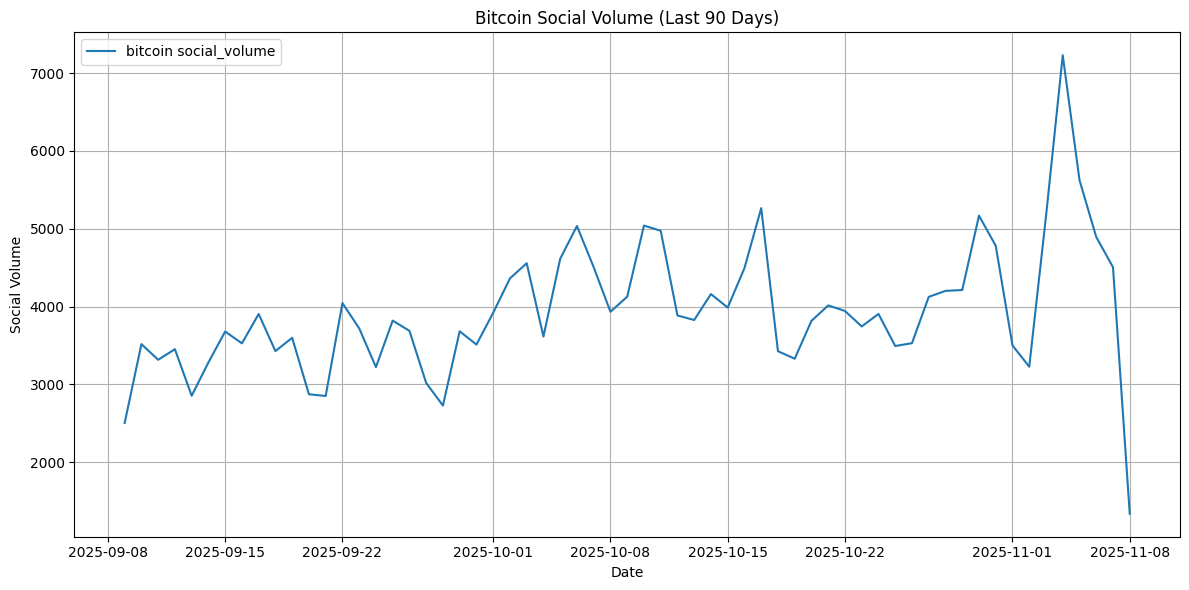

Graphic generated successfully!


In [4]:
from google.colab import userdata
import matplotlib.pyplot as plt

# Get Santiment API key securely from Colab secrets
try:
    santiment_api_key = userdata.get('SANTIMENT_API_KEY')
except userdata.SecretNotFoundError:
    print("Error: SANTIMENT_API_KEY not found in Colab secrets. Please add it.")
    santiment_api_key = None

if santiment_api_key:
    client = SantimentClient(santiment_api_key)

    # Define parameters for data retrieval
    slug = 'bitcoin'
    metric = 'social_volume'
    to_date = datetime.now()
    from_date = to_date - timedelta(days=90) # Last 90 days
    interval = '1d'

    print(f"Fetching {metric} for {slug} from {from_date.strftime('%Y-%m-%d')} to {to_date.strftime('%Y-%m-%d')}...")

    # Get social volume data
    social_volume_data = client.get_social_volume(slug, from_date, to_date, interval)

    if social_volume_data:
        df_social_volume = client.to_dataframe(social_volume_data)

        # Create the graphic
        plt.figure(figsize=(12, 6))
        plt.plot(df_social_volume.index, df_social_volume['value'], label=f'{slug} {metric}')
        plt.title(f'{slug.capitalize()} Social Volume (Last 90 Days)')
        plt.xlabel('Date')
        plt.ylabel('Social Volume')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        print("Graphic generated successfully!")
    else:
        print(f"No data retrieved for {slug} {metric}. Please check the slug, metric, or API key.")
else:
    print("Santiment API key is not available. Cannot proceed with data retrieval and graphic generation.")